## 1.2 NLP Analysis

In [ ]:
# Import packages
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import numpy as np
import string
import re
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
import ast

from sklearn.cluster import KMeans

# Text analysis
import re
import nltk 
from nltk import sent_tokenize, word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# pip install tqdm
# pip install wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\25mad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("data/df_text_clean.csv")
df.head()

,text,url_html,clean_w_numbers,gesetzesverweise,clean_wo_numbers,datum,entscheidungsjahr,entscheidung_typ,spruchkoerper_typ,spruchkoerper_az,registerzeichen,pressemitteilung,richter
0,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerden 1. des Herrn H. , 2...","['§ 2 Absatz 2 des Bundeswahlgesetzes, als dan...",die Verfassungsbeschwerden des Herrn des Herrn...,1951-09-09,1951,B,S,2,BvQ,NaN,Dr. Katz|Dr. Fröhlich|Wolff|Dr. Roediger|Dr. K...
1,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 189/09 -\n...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde 1. der Frau W…, 2. d...","['§ 93b in Verbindung mit § 93a BVerfGG', '§ 8...",die Verfassungsbeschwerde der Frau des Herrn d...,1952-09-10,1952,B,S,1,BvR,NaN,Dr. Dr.|Höpker-Aschoff|Ellinghaus|Dr. Scheffle...
2,BUNDESVERFASSUNGSGERICHT\n\n- 2 BvR 432/07 -\n...,https://www.bundesverfassungsgericht.de/Shared...,die Verfassungsbeschwerden des Herrn M... I. g...,"['§ 93b in Verbindung mit § 93a BVerfGG', 'Art...",die Verfassungsbeschwerden des Herrn gegen den...,1952-10-10,1952,B,S,1,BvR,NaN,Dr. Dr.|Höpker-Aschoff|Ellinghaus|Dr. Heiland|...
3,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 2037/10 -\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde 1. der Frau L…, 2. d...","['§ 178a SGG', 'Art. 103 Abs. 1 GG', '§ 3 Abs....",die Verfassungsbeschwerde der Frau der Minderj...,1957-01-16,1957,U,S,1,BvR,NaN,Dr. Wintrich|Dr. Scheffler|Dr. Heiland|Dr. Hec...
4,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde der Frau R..., KÖRIN...","['§ 93b in Verbindung mit § 93a BVerfGG', '§ 5...",die Verfassungsbeschwerde der Frau KÖRING Rech...,1958-01-15,1958,U,S,1,BvR,NaN,NaN


### 0.1 Helper Functions

In [3]:
import spacy
nlp = spacy.load("de_core_news_sm")
stop_words = set(stopwords.words("german"))

def preprocess_text(text):
    # Stopword and punctuation
    processed_texts = []
    for doc in nlp.pipe(text, batch_size=50):
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
        processed_texts.append(tokens)
    return processed_texts

def remove_stopwords(tokens):
    # Remove stopwords, as well as any punctuation with
    filtered_tokens = [
        word.lower() for word in tokens 
        if word.lower() not in stop_words and word not in string.punctuation
    ]
    return filtered_tokens

def remove_single_letters(tokens):
    filtered_tokens = [word for word in tokens if len(word) > 1]
    return filtered_tokens

In [4]:
# Remove any words that came up during analysis and are noted down in the extended_stopwords.txt
with open("extended_stopwords.txt", "r", encoding="utf-8") as f:
    custom_stopwords = set(f.read().splitlines())

with open("german_stopwords_full.txt", "r", encoding="utf-8") as f:
    german_stopwords_extended = set(f.read().splitlines())

Weil Lemmatization hier zu langsam ist, bietet es sich stattdessen an nach den religiösen Begriffen durch spezifische Regex zu suchen.

In [5]:
religious_keywords = ["glaubensfreiheit", "religiös", "religion", "religionsgemeinschaft", "religionsfreiheit", "säkular",
                      "gott", "christentum", "kirche", "bibel",
                      "islam", "moschee", "kopftuch","koran",
                      "tora", "synagoge", "moschee", 
                     ]

def contains_religion(text):
    matches = [k for k in religious_keywords if re.search(rf"\b{k}\b", str(text), re.IGNORECASE)]
    return bool(matches), ", ".join(matches) if matches else None

In [6]:
def plot_mfw(filtered_tokens):
    lst_tokens = [word for sublist in filtered_tokens for word in sublist]

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
    fig.suptitle("Most Frequent Words", fontsize=15)

    ## Unigrams
    dic_words_freq = FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(10), columns=["Word", "Freq"])
    dtf_uni.set_index("Word").sort_values(by="Freq").plot(
        kind="barh", title="Unigrams", ax=ax[0], legend=False, color="steelblue"
    )
    ax[0].set(ylabel=None)

    ## Bigrams
    dic_words_freq = FreqDist(nltk.bigrams(lst_tokens))
    dtf_bi = pd.DataFrame(dic_words_freq.most_common(10), columns=["Word", "Freq"])
    dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(x))
    dtf_bi.set_index("Word").sort_values(by="Freq").plot(
        kind="barh", title="Bigrams", ax=ax[1], legend=False, color="darkorange"
    )
    ax[1].set(ylabel=None)

    ## Trigrams 
    dic_words_freq = FreqDist(nltk.trigrams(lst_tokens))
    dtf_tri = pd.DataFrame(dic_words_freq.most_common(10), columns=["Word", "Freq"])
    dtf_tri["Word"] = dtf_tri["Word"].apply(lambda x: " ".join(x))
    dtf_tri.set_index("Word").sort_values(by="Freq").plot(
        kind="barh", title="Trigrams", ax=ax[2], legend=False, color="forestgreen"
    )
    ax[2].set(ylabel=None)

    ## Quadgrams (4-grams)
    dic_words_freq = FreqDist(nltk.ngrams(lst_tokens, 4))
    dtf_quad = pd.DataFrame(dic_words_freq.most_common(10), columns=["Word", "Freq"])
    dtf_quad["Word"] = dtf_quad["Word"].apply(lambda x: " ".join(x))
    dtf_quad.set_index("Word").sort_values(by="Freq").plot(
        kind="barh", title="Quadgrams", ax=ax[3], legend=False, color="purple"
    )
    ax[3].set(ylabel=None)

    plt.tight_layout()
    plt.show()


## 1.0 NLP-Analysis

Da wir bereits im ersten Notebook die Rechtsprechungen gesäubert haben, können wir nun zur eigentlichen Korpusverarbeitung kommen. Diese Sektion ist aufgeteilt in mehrere Unterkapitel:
- ...
- 1.1 N-grams
- 1.2 

In [7]:
df.columns

Index(['text', 'url_html', 'clean_w_numbers', 'gesetzesverweise',
       'clean_wo_numbers', 'datum', 'entscheidungsjahr', 'entscheidung_typ',
       'spruchkoerper_typ', 'spruchkoerper_az', 'registerzeichen',
       'pressemitteilung', 'richter'],
      dtype='object')

In [8]:
lst_stopwords = nltk.corpus.stopwords.words("german")

def utils_preprocess_text(text):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in german_stopwords_extended and word not in lst_stopwords and word not in custom_stopwords]
        
    ## back to string from list
    text = " ".join(lst_text)
    return text

### 1.1. Tokenization
Da die Texte schon gründlich gesäubert worden sind, wird als Nächstes der gesäuberte Text tokenisiert und anschließend von Stoppwörtern befreit.

In [9]:
df["processed_wo_numbers"] = df["clean_wo_numbers"].apply(utils_preprocess_text)

In [10]:
df["processed_wo_numbers"]

0       verfassungsbeschwerden herrn herrn herrn josef...
1       verfassungsbeschwerde herrn joseph hessischen ...
2       verfassungsbeschwerden herrn bundesgerichtshof...
3       verfassungsbeschwerde minderjährigen gesetzlic...
4       verfassungsbeschwerde köring rechtsanwälte ste...
                              ...                        
8944    verfassungsbeschwerde herrn herrn bundesgerich...
8945    verfassungsbeschwerde herrn bewilligungsentsch...
8946    eingriffsgewicht ursprünglichen erhebung hinau...
8947    anträge wege einstweiligen anordnung bescheid ...
8948    antrag festzustellen desideriusstiftung ev ger...
Name: processed_wo_numbers, Length: 8949, dtype: object

### 1.2. Lemmatization
Um besseres Filtern der Entscheidungen ermöglichen zu können, wird der von Stoppwörtern-befreite Text lemmatisiert. 

In [11]:
import spacy
nlp = spacy.load('de_core_news_sm')

lemma_text_list = []
for doc in tqdm(nlp.pipe(df["processed_wo_numbers"], disable=["parser", "ner"])):
    lemma_text_list.append(" ".join([token.lemma_ for token in doc]))
df["text_lemma"] = lemma_text_list

8949it [03:13, 46.30it/s] 


In [12]:
df.head()

,text,url_html,clean_w_numbers,gesetzesverweise,clean_wo_numbers,datum,entscheidungsjahr,entscheidung_typ,spruchkoerper_typ,spruchkoerper_az,registerzeichen,pressemitteilung,richter,processed_wo_numbers,text_lemma
0,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerden 1. des Herrn H. , 2...","['§ 2 Absatz 2 des Bundeswahlgesetzes, als dan...",die Verfassungsbeschwerden des Herrn des Herrn...,1951-09-09,1951,B,S,2,BvQ,NaN,Dr. Katz|Dr. Fröhlich|Wolff|Dr. Roediger|Dr. K...,verfassungsbeschwerden herrn herrn herrn josef...,verfassungsbeschwerd Herr Herr Herr Josef Herr...
1,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 189/09 -\n...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde 1. der Frau W…, 2. d...","['§ 93b in Verbindung mit § 93a BVerfGG', '§ 8...",die Verfassungsbeschwerde der Frau des Herrn d...,1952-09-10,1952,B,S,1,BvR,NaN,Dr. Dr.|Höpker-Aschoff|Ellinghaus|Dr. Scheffle...,verfassungsbeschwerde herrn joseph hessischen ...,Verfassungsbeschwerde Herr Joseph hessisch Ver...
2,BUNDESVERFASSUNGSGERICHT\n\n- 2 BvR 432/07 -\n...,https://www.bundesverfassungsgericht.de/Shared...,die Verfassungsbeschwerden des Herrn M... I. g...,"['§ 93b in Verbindung mit § 93a BVerfGG', 'Art...",die Verfassungsbeschwerden des Herrn gegen den...,1952-10-10,1952,B,S,1,BvR,NaN,Dr. Dr.|Höpker-Aschoff|Ellinghaus|Dr. Heiland|...,verfassungsbeschwerden herrn bundesgerichtshof...,verfassungsbeschwerd Herr Bundesgerichtshof Ur...
3,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 2037/10 -\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde 1. der Frau L…, 2. d...","['§ 178a SGG', 'Art. 103 Abs. 1 GG', '§ 3 Abs....",die Verfassungsbeschwerde der Frau der Minderj...,1957-01-16,1957,U,S,1,BvR,NaN,Dr. Wintrich|Dr. Scheffler|Dr. Heiland|Dr. Hec...,verfassungsbeschwerde minderjährigen gesetzlic...,Verfassungsbeschwerde minderjährigen gesetzlic...
4,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde der Frau R..., KÖRIN...","['§ 93b in Verbindung mit § 93a BVerfGG', '§ 5...",die Verfassungsbeschwerde der Frau KÖRING Rech...,1958-01-15,1958,U,S,1,BvR,NaN,NaN,verfassungsbeschwerde köring rechtsanwälte ste...,Verfassungsbeschwerde Köring rechtsanwäln Steu...


### 1.3 Filtern nach Religion & Explorative Analysis
Um Urteile zu finden, die tatsächlich Religion präsent haben wird durch eine Liste von religiösen Schlüsselbegriffen iteriert.

In [13]:
df[["is_religious", "religious_terms"]] = df["text_lemma"].apply(contains_religion).apply(pd.Series)

In [82]:
df_religious = df[df["is_religious"] == True]
df_religious.head(2)

,text,url_html,clean_w_numbers,gesetzesverweise,clean_wo_numbers,datum,entscheidungsjahr,entscheidung_typ,spruchkoerper_typ,spruchkoerper_az,registerzeichen,pressemitteilung,richter,processed_wo_numbers,text_lemma,is_religious,religious_terms
30,Leitsätze\...,https://www.bundesverfassungsgericht.de/Shared...,das Vorliegen der Eheschließungsvoraussetzunge...,['Art. 13 Abs. 1 EGBGB berufene Recht des Staa...,das Vorliegen der Eheschließungsvoraussetzunge...,1992-12-01,1992,B,S,1,BvR,NaN,Herzog|Henschel|Seidl|Grimm|Söllner|Dieterich|...,vorliegen eheschließungsvoraussetzungen staate...,vorliegen eheschließungsvoraussetzung Staat an...,True,religiös
120,BUNDESVERFASSUNGSGERICHT\n\n- 2 BvL 3/20 -\n\n...,https://www.bundesverfassungsgericht.de/Shared...,den Verkehr mit Betäubungsmitteln für verfassu...,['Art. 2 Abs. 1 — auch in Verbindung mit Art. ...,den Verkehr mit Betäubungsmitteln für verfassu...,1996-01-11,1996,B,K,1,BvR,NaN,Seidl|Grimm|Hömig,verkehr betäubungsmitteln verfassungswidrig um...,Verkehr betäubungsmitteln verfassungswidrig Um...,True,glaubensfreiheit


<Axes: xlabel='year', ylabel='decisions'>

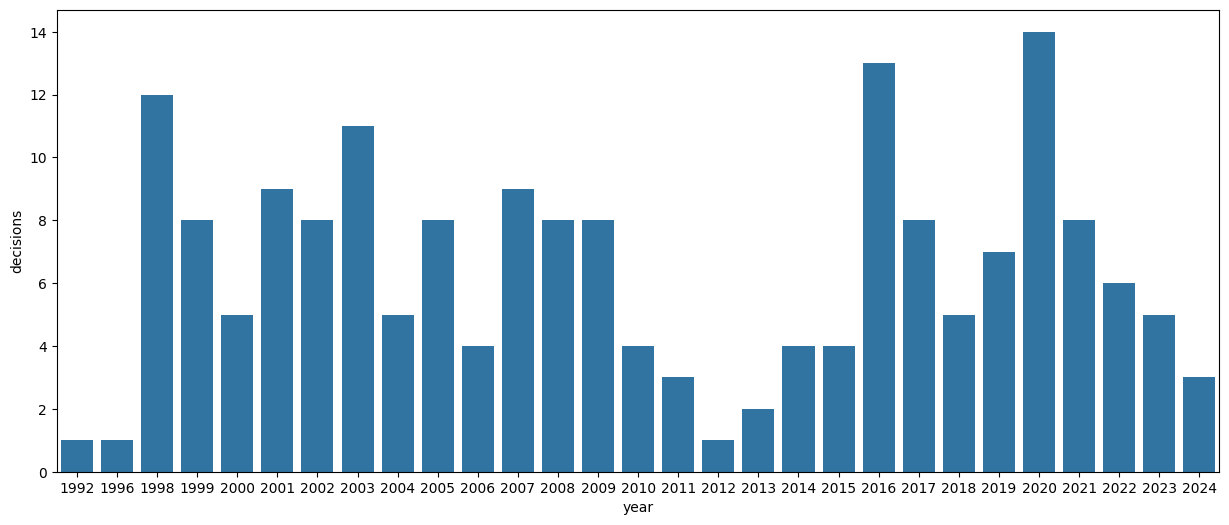

In [19]:
# Anzahl der Entscheidungen pro Jahr
total_reli = df_religious['entscheidungsjahr'].value_counts().sort_index()
total_df = pd.DataFrame({
    'year': total_reli.index,
    'decisions': total_reli.values
})

fig = plt.figure(figsize=(15,6))
sns.barplot(data=total_df, x="year", y="decisions")

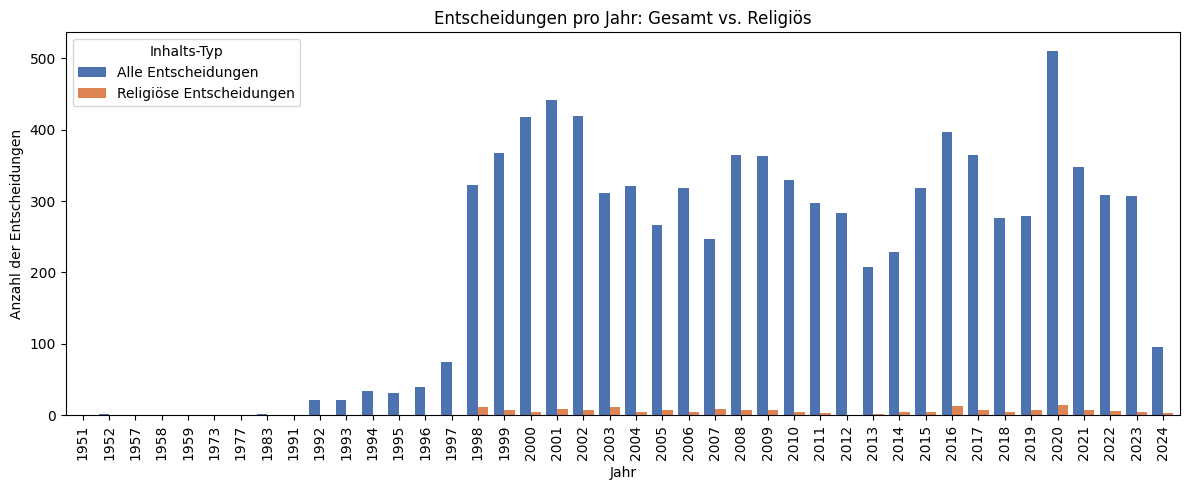

In [20]:
# Relative decisions/year
total_per_year = df['entscheidungsjahr'].value_counts().sort_index()
religious_per_year = df_religious['entscheidungsjahr'].value_counts().sort_index()
comparison_df = pd.DataFrame({
    'Alle Entscheidungen': total_per_year,
    'Religiöse Entscheidungen': religious_per_year
}).fillna(0)

comparison_df.plot(kind='bar', figsize=(12, 5), color=['#4C72B0', '#DD8452'], width=0.8)
plt.title('Entscheidungen pro Jahr: Gesamt vs. Religiös')
plt.ylabel('Anzahl der Entscheidungen')
plt.xlabel('Jahr')
plt.legend(title='Inhalts-Typ')
plt.tight_layout()
plt.show()

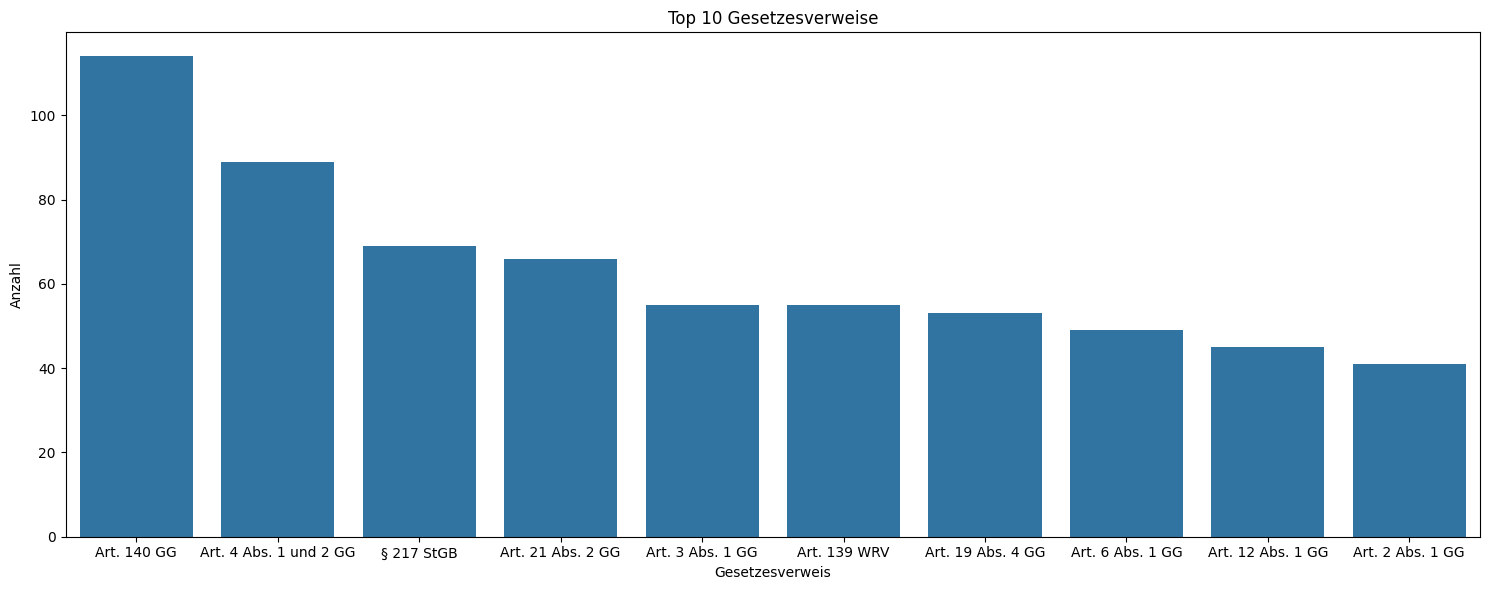

In [85]:
law_refs = df_religious['gesetzesverweise'].dropna().apply(ast.literal_eval)
flat_list = [item for sublist in law_refs for item in sublist]
top_list = Counter(flat_list).most_common(10)

top_df = pd.DataFrame(top_list, columns=['gesetzesverweis', 'anzahl'])

plt.figure(figsize=(15, 6))
sns.barplot(x='gesetzesverweis', y='anzahl', data=top_df)
plt.title('Top 10 Gesetzesverweise')
plt.xlabel("Gesetzesverweis")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

Zu erwartende Ergebnisse hier sind eindeutig:
- Art. 140 GG
- Art. 4 GG, sowie
- Art. 139 WRV 

Da all diese Gesetzesverweise auch relgiöse Hintegründe haben, bzw. sich mit der Religionsfreiheit sowie Weltanschauung befassen. 
Überraschend hingegen sind:

- § 217 StGB (2015 abgeschafft worden) - Selbsttötung
- Art. 21 GG - Politikwahl


C:\Users\25mad\AppData\Local\Temp\ipykernel_9088\2313362866.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_religious[gesetz] = df_religious['gesetzesverweise'].apply(lambda x: count_gesetzesverweise(x, [gesetz]))


<Figure size 1200x600 with 0 Axes>

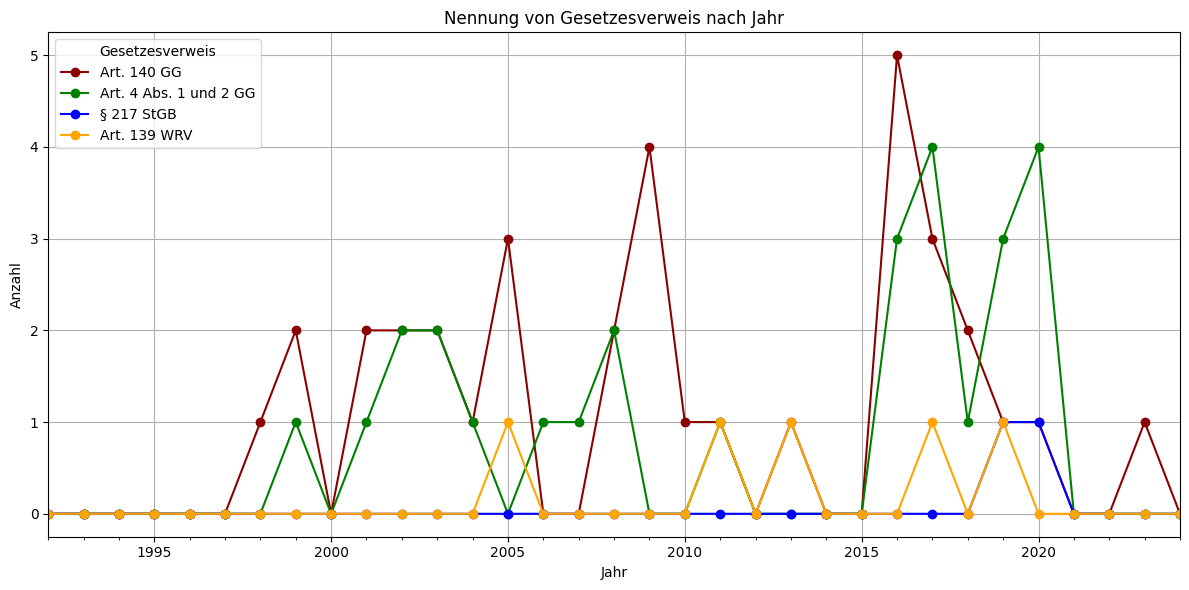

In [150]:
gesetzes_interested = ["Art. 140 GG", "Art. 4 Abs. 1 und 2 GG", "§ 217 StGB", "Art. 139 WRV"]

def count_gesetzesverweise(row, gesetz_list):
    count = 0
    if isinstance(row, list):
        for item in row:
            if any(gesetz.lower() in item.lower() for gesetz in gesetz_list):
                count += 1
    elif isinstance(row, str):
        if any(gesetz.lower() in row.lower() for gesetz in gesetz_list):
            count += 1
    return count

# Count occurrences of the specified gesetzesverweise per row
for gesetz in gesetzes_interested:
    df_religious[gesetz] = df_religious['gesetzesverweise'].apply(lambda x: count_gesetzesverweise(x, [gesetz]))

# Resample by year and sum the counts for each gesetzesverweis
yearly_counts = df_religious[gesetzes_interested].resample("Y").sum()

# Plot the results
plt.figure(figsize=(12, 6))
yearly_counts.plot(marker='o', color=['darkred', 'green', "blue", "orange"], figsize=(12, 6))

plt.title("Nennung von Gesetzesverweis nach Jahr")
plt.xlabel("Jahr")
plt.ylabel("Anzahl")
plt.legend(title="Gesetzesverweis", labels=gesetzes_interested)
plt.grid(True)
plt.tight_layout()
plt.show()

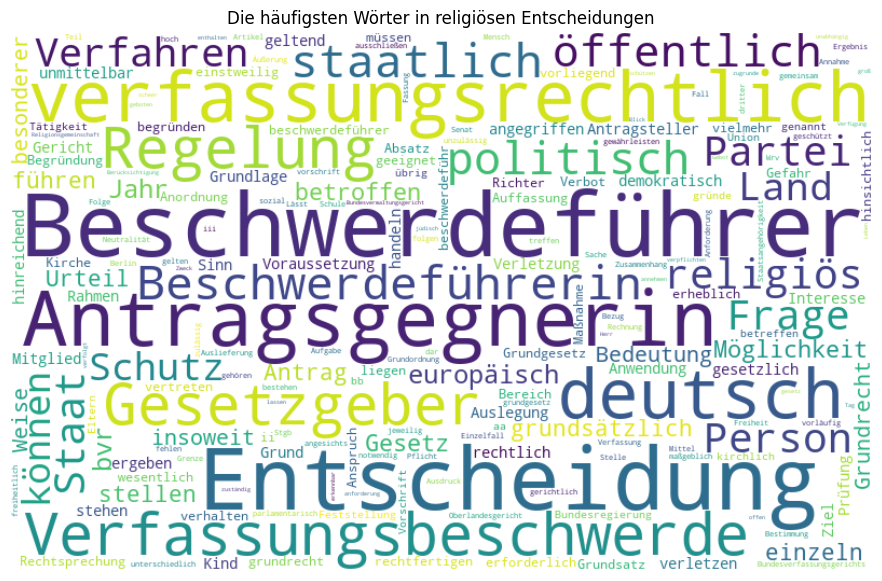

In [83]:
all_words = ' '.join(df_religious['text_lemma'])
word_freq = Counter(all_words.split())

wordcloud = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Die häufigsten Wörter in religiösen Entscheidungen')
plt.show()

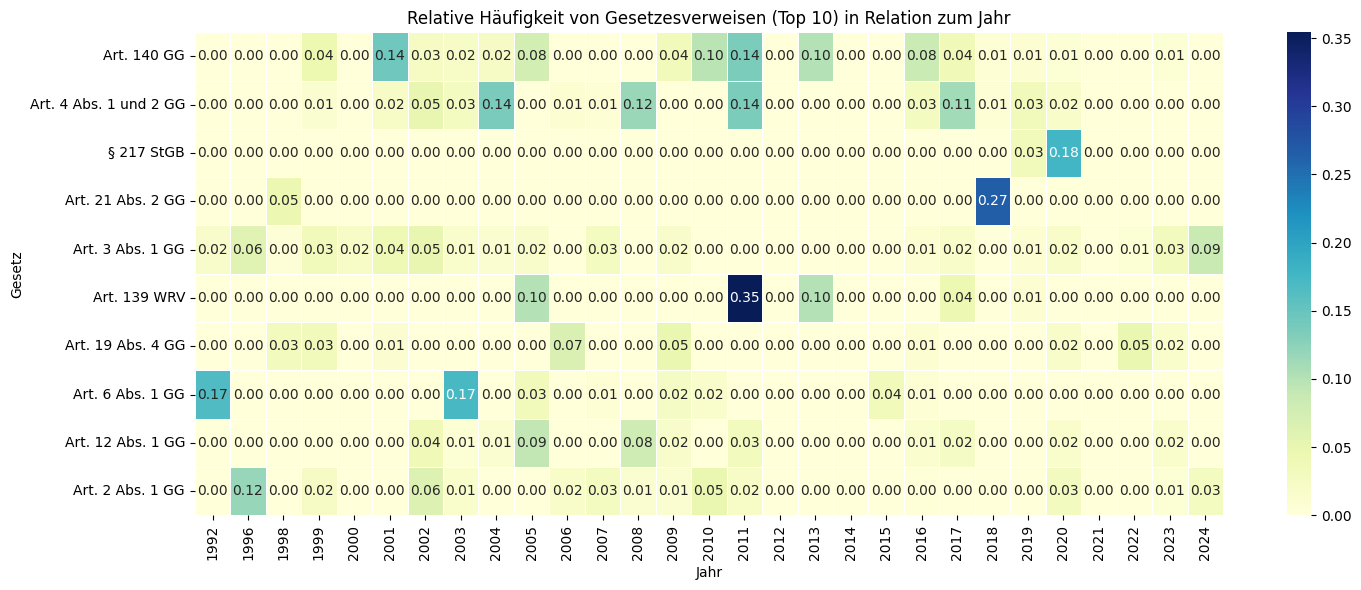

In [86]:
df_reli_clean = df_religious.dropna(subset=['gesetzesverweise', 'entscheidungsjahr']).copy()
df_reli_clean['gesetzesverweise'] = df_reli_clean['gesetzesverweise'].apply(ast.literal_eval)

df_2 = df_reli_clean.explode('gesetzesverweise')
law_year_counts = df_2.groupby(['entscheidungsjahr', 'gesetzesverweise']).size().unstack(fill_value=0)

law_year_counts_relative = law_year_counts.div(law_year_counts.sum(axis=1), axis=0)

top_laws = df_2['gesetzesverweise'].value_counts().nlargest(10).index
law_year_counts_relative = law_year_counts_relative[top_laws]

plt.figure(figsize=(15, 6))  
sns.heatmap(law_year_counts_relative.T, cmap='YlGnBu', linewidths=0.5, annot=True, fmt='.2f')
plt.title('Relative Häufigkeit von Gesetzesverweisen (Top 10) in Relation zum Jahr')
plt.xlabel('Jahr')
plt.ylabel('Gesetz')
plt.tight_layout()  
plt.show()

Mitunter sind hier die Jahr 2011, 2018 und 2020 interessant nach erstmaliger Betrachtung der Häufigkeit von den Gesetzesverweisen.

In [87]:
all_words_1 = ' '.join(df_religious[df_religious["entscheidungsjahr"] == 2001]['text_lemma'])
word_freq_1 = Counter(all_words_1.split())
wordcloud_1 = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_freq_1)

all_words_2 = ' '.join(df_religious[df_religious["entscheidungsjahr"] == 2018]['text_lemma'])
word_freq_2 = Counter(all_words_2.split())
wordcloud_2 = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_freq_2)

all_words_3 = ' '.join(df_religious[df_religious["entscheidungsjahr"] == 2020]['text_lemma'])
word_freq_3 = Counter(all_words_3.split())
wordcloud_3 = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_freq_3)

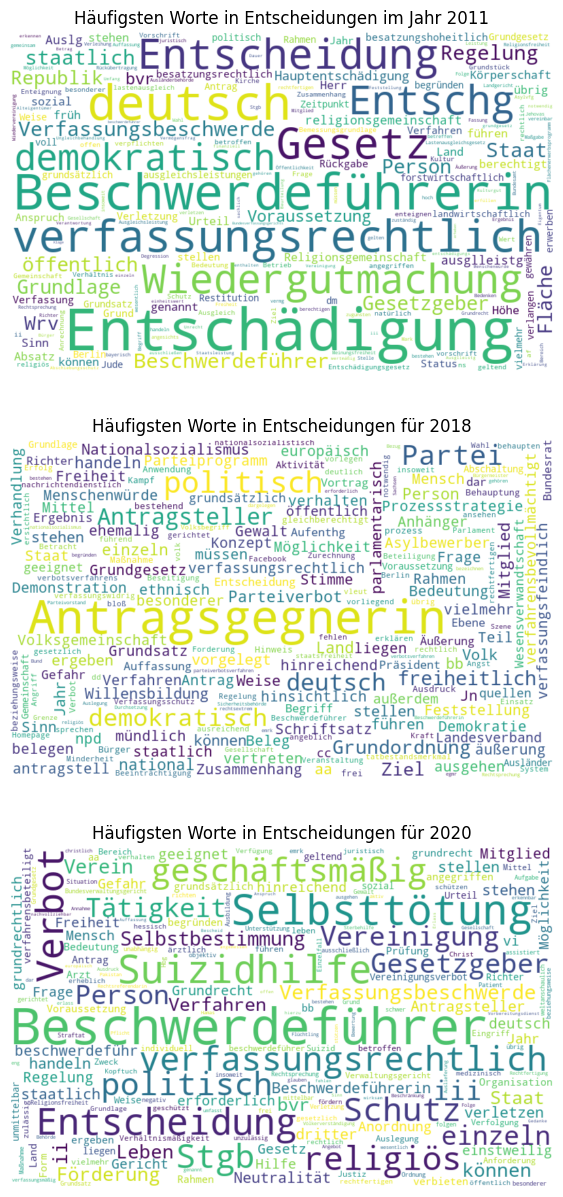

In [89]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

ax[0].imshow(wordcloud_1, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Häufigsten Worte in Entscheidungen im Jahr 2011')

ax[1].imshow(wordcloud_2, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Häufigsten Worte in Entscheidungen für 2018')

ax[2].imshow(wordcloud_3, interpolation='bilinear')
ax[2].axis('off')
ax[2].set_title('Häufigsten Worte in Entscheidungen für 2020')

plt.show()

## 1.4 Kollokationen und N-Gramme

In [92]:
corpus = df_religious["text_lemma"]
tokens = corpus.apply(lambda x: word_tokenize(x))
filter_list = ["beschwerdeführer", "entscheidung", "bvr", "artikel", "absatz", "verfassungsbeschwerde", "herr", "bekanntmachung", "einstweilig", "einstimmig",
               ]
 
filtered_tokens = tokens.apply(lambda x: [word for word in x if word.lower() not in filter_list])

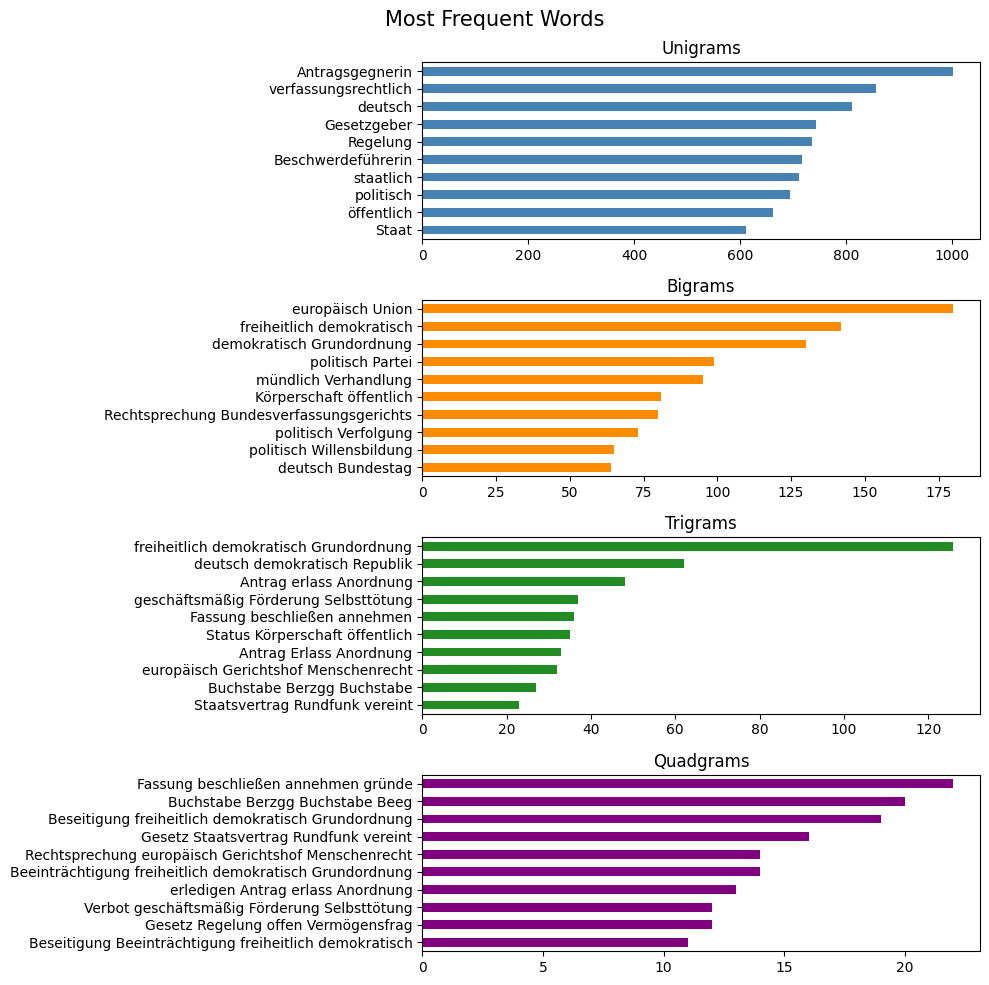

In [93]:
plot_mfw(filtered_tokens)

Besonders die 3-grams und 4-grams sind für die Untersuchung von Rechtsprechung interessant. Auffälligkeiten sind dabei insbesondere:
- Bezug auf "(Beeinträchtigung) freiheitlich demokratische Grundordnung"
- "europäisch Gerichtshof Menschenrecht"
- "Verbot geschäftsmäßig Förderung Selbsttötung"
- "Status Körperschaft öffentlich"

### 1.5 Keywords

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_religious["text_lemma"])
feature_names = vectorizer.get_feature_names_out()

def get_top_keywords(row_idx, top_n=5):
    row = tfidf_matrix[row_idx]
    scores = row.toarray().flatten()
    top_indices = scores.argsort()[::-1][:top_n]
    return [feature_names[i] for i in top_indices if scores[i] > 0]

df_religious["top_keywords"] = [get_top_keywords(i, top_n=5) for i in range(tfidf_matrix.shape[0])]

C:\Users\25mad\AppData\Local\Temp\ipykernel_9088\1736652830.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_religious["top_keywords"] = [get_top_keywords(i, top_n=5) for i in range(tfidf_matrix.shape[0])]


In [96]:
df_religious[["text_lemma", "top_keywords"]].head()

,text_lemma,top_keywords
30,vorliegen eheschließungsvoraussetzung Staat an...,"[egbgb, ehe, eheschließung, inländisch, unwirk..."
120,Verkehr betäubungsmitteln verfassungswidrig Um...,"[btmg, betäubungsmittel, gramm, unerlaubt, can..."
277,Verfassungsbeschwerde Herr Amtsgerichts heinsb...,"[kind, familiengerichen, umgangsausschluss, um..."
307,Antrag feststellen nationaldemokratisch Partei...,"[antragsgegnerin, partei, freiheitlich, grundo..."
388,Verfassungsbeschwerde bevollmächtigen azr Vere...,"[verein, yogaprodukt, seminarbetriebs, vertrie..."


[('beschwerdeführer', 23), ('beschwerdeführerin', 20), ('kind', 9), ('antragsteller', 8), ('auslieferung', 7), ('stgb', 6), ('äußerung', 6), ('religionsunterricht', 6), ('religionsgemeinschaft', 6), ('oberlandesgericht', 6), ('einstweilig', 6), ('religiös', 6), ('partei', 5), ('verein', 5), ('politisch', 5), ('kirchlich', 5), ('kopftuch', 5), ('antragstellerin', 5), ('asylvfg', 4), ('bundesgerichtshof', 4)]


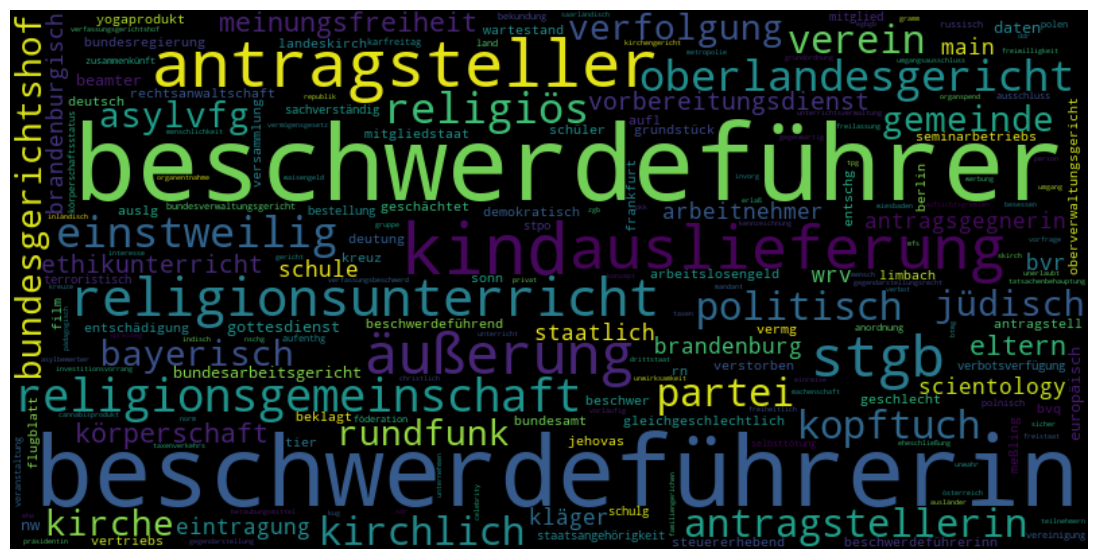

In [108]:
# visualize top keywords after all 
all_keywords = [kw for sublist in df_religious["top_keywords"] for kw in sublist]
keyword_freq = Counter(all_keywords)
print(keyword_freq.most_common(20))

text = ' '.join(all_keywords)
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Sehr auffällig aus den bestehenden Schlüsselwörtern scheinen hier die Begriffe Kind, Religionsunterricht, Auslieferung, Religionsgemeinschaft, Partei sowie spezielle Begriffe wie Kopftuch und politisch zu sein. 
Dies ist aber vor dem Hintergrund der sog. Kopftuch-Urteile nicht allzu verwunderlich.

C:\Users\25mad\AppData\Local\Temp\ipykernel_9088\1294526866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_religious[kw] = df_religious["text_lemma"].str.count(kw, flags=re.IGNORECASE)


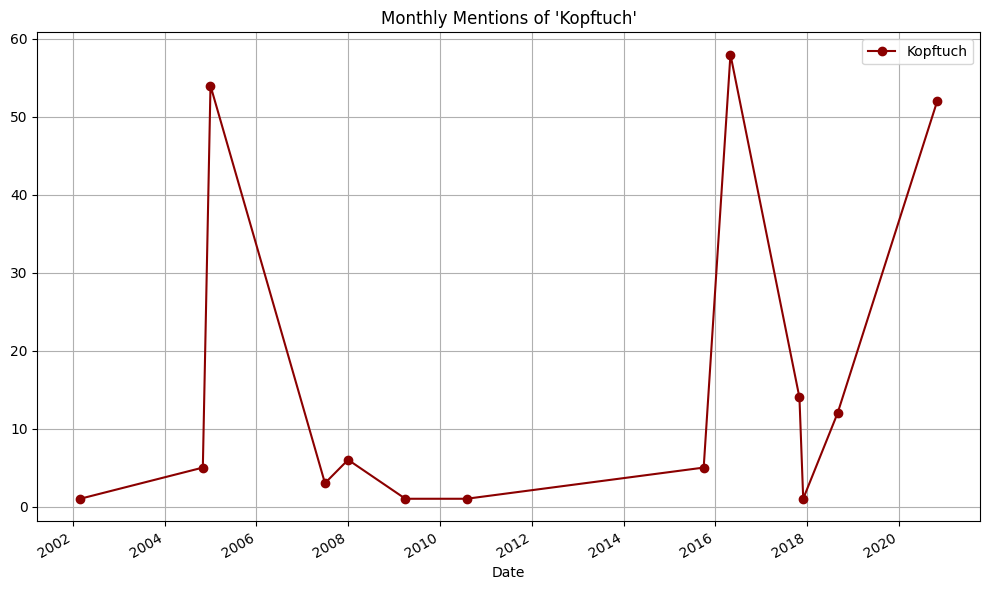

In [137]:
keywords = ["Kopftuch"]
for kw in keywords:
    df_religious[kw] = df_religious["text_lemma"].str.count(kw, flags=re.IGNORECASE)


monthly_counts = df_religious[keywords].resample("M").sum()
filtered_counts = monthly_counts[monthly_counts["Kopftuch"] > 0]

filtered_counts.plot(marker='o', color='darkred', figsize=(10, 6))
plt.title("Monthly Mentions of 'Kopftuch'")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


### 1.8 Topic Clustering

In [159]:
filter_list = ["beschwerdeführer", "beschwerdeführerin","entscheidung", "antragsteller","antragstellerin", 
               "bvr", "artikel", "absatz", "verfassungsbeschwerde", "herr", "bekanntmachung", "einstweilig", "einstimmig"]

# Create a regex pattern that matches any of the words in the filter list (case-insensitive)
filter_pattern = r'\b(?:' + '|'.join(map(re.escape, filter_list)) + r')\b'

# Remove the words in filter_list from 'text_lemma'
df_religious['text_lemma_filtered'] = df_religious['text_lemma'].apply(lambda text: re.sub(filter_pattern, '', text, flags=re.IGNORECASE))
df_religious['text_lemma_filtered'] = df_religious['text_lemma_filtered'].str.replace(r'\s+', ' ', regex=True).str.strip()


C:\Users\25mad\AppData\Local\Temp\ipykernel_9088\4146404991.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_religious['text_lemma_filtered'] = df_religious['text_lemma'].apply(lambda text: re.sub(filter_pattern, '', text, flags=re.IGNORECASE))
C:\Users\25mad\AppData\Local\Temp\ipykernel_9088\4146404991.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_religious['text_lemma_filtered'] = df_religious['text_lemma_filtered'].str.replace(r'\s+', ' ', regex=True).str.strip()


In [173]:
# Kmeans + TFIDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_religious['text_lemma_filtered'])

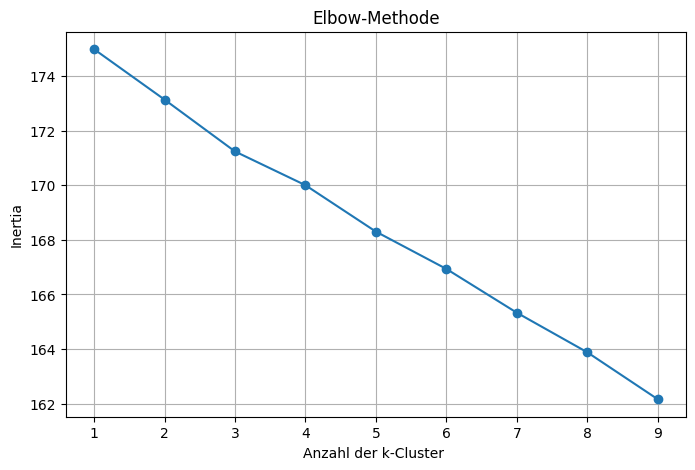

In [177]:
WCSS=[]
for i in range(1,10):
  kmeans=KMeans(n_clusters=i,n_init='auto')
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)
WCSS

plt.figure(figsize=(8, 5))
plt.plot(range(1,10), WCSS, marker='o')
plt.title("Elbow-Methode")
plt.xlabel("Anzahl der k-Cluster ")
plt.ylabel("Inertia")
plt.grid(True)
plt.xticks(range(1,10))
plt.show()


Es gibt keinen eindeutigen Ellbogen hier, ein leichter Knick befindet sich bei einer Anzahl von etwa 5 Clustern.

In [180]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
df_religious.loc[:, 'cluster'] = kmeans.labels_


terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(", ".join([terms[ind] for ind in order_centroids[i, :10]]))
    print()

Cluster 0:
kind, eltern, religiös, staat, schule, kopftuch, mutter, staatlich, glauben, staatsangehörigkeit

Cluster 1:
bundesgerichtshof, antragsgegnerin, wrv, kirchlich, urteil, vermg, bundesarbeitsgericht, staatlich, deutsch, äußerung

Cluster 2:
anordnung, antrag, erlass, äußerung, verein, meinungsfreiheit, oberlandesgericht, öffentlich, vorläufig, kläger

Cluster 3:
auslieferung, gesetzgeber, politisch, europäisch, regelung, verfassungsrechtlich, oberlandesgericht, deutsch, jahr, verfolgung

Cluster 4:
religionsgemeinschaft, staatlich, religionsunterricht, religiös, land, schüler, kirchlich, öffentlich, jüdisch, kirche



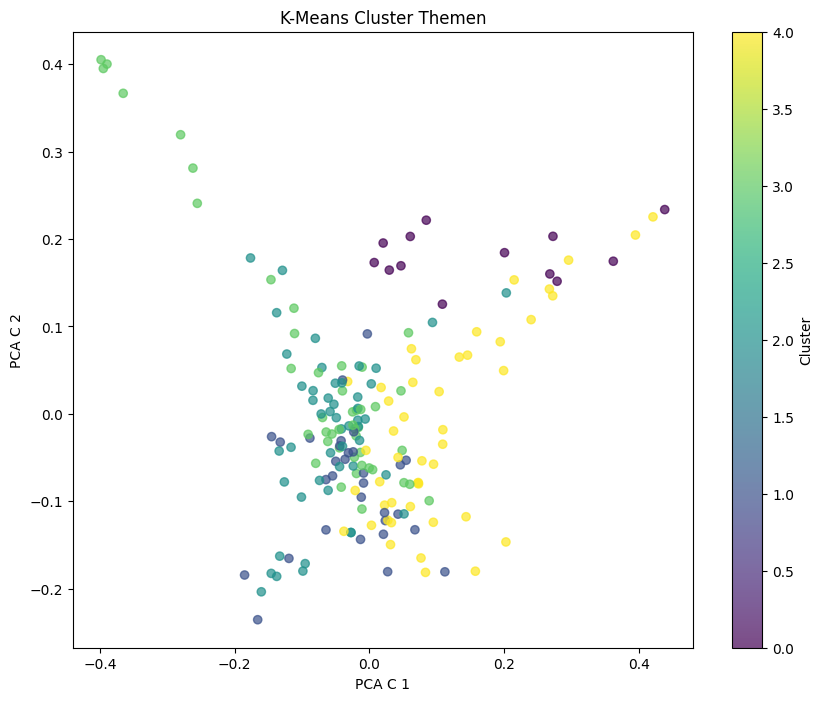

In [182]:
from sklearn.decomposition import PCA

# Plot clusters
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df_religious['cluster'], alpha=0.7)
plt.title("K-Means Cluster Themen")
plt.xlabel("PCA C 1")
plt.ylabel("PCA C 2")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
# pip install wordcloud
# pip install germansentiment

In [48]:
# sentiment analysis next...

In [50]:
from germansentiment import SentimentModel

model = SentimentModel()

In [51]:
def extract_sentences(text, keywords):
    sentences = sent_tokenize(text) 
    return [sentence for sentence in sentences if any(kw in sentence.lower() for kw in keywords)]


In [52]:
# Get sentences where religous keyword appears
df_religious["sentences_with_keywords"] = df_religious["clean_w_numbers"].apply(lambda x: extract_sentences(x, religious_keywords))

C:\Users\25mad\AppData\Local\Temp\ipykernel_9088\628665653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_religious["sentences_with_keywords"] = df_religious["clean_w_numbers"].apply(lambda x: extract_sentences(x, religious_keywords))


In [53]:
# Check if all processed correctly
df_religious[df_religious["sentences_with_keywords"].apply(lambda x: len(x) == 0)].shape


(0, 19)

In [54]:
# Predict the sentiment for the religion-present sentences
df_religious["sentiment"] = df_religious["sentences_with_keywords"].apply(lambda x: model.predict_sentiment(x))

C:\Users\25mad\AppData\Local\Temp\ipykernel_9088\1859167636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_religious["sentiment"] = df_religious["sentences_with_keywords"].apply(lambda x: model.predict_sentiment(x))


In [55]:
df_religious["sentiment"]

30               [neutral, neutral, neutral, neutral]
120                                         [neutral]
277                                         [neutral]
307                       [neutral, neutral, neutral]
388                                         [neutral]
                            ...                      
8838                                        [neutral]
8846                               [neutral, neutral]
8857                      [neutral, neutral, neutral]
8866    [neutral, neutral, neutral, neutral, neutral]
8940                                        [neutral]
Name: sentiment, Length: 184, dtype: object